In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import gensim
import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweets.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
train.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [6]:
test.isna().sum()

id       0
tweet    0
dtype: int64

In [7]:
train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Tweets')

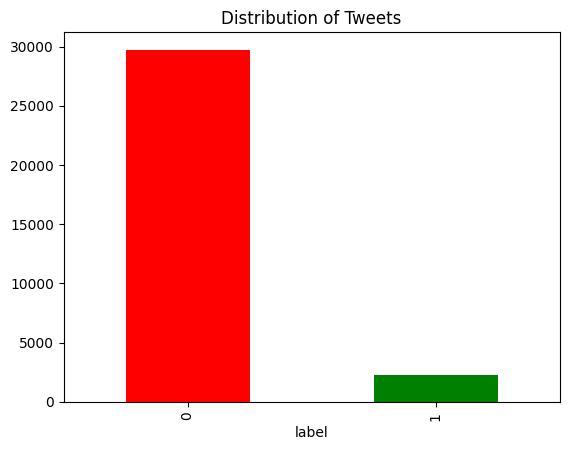

In [8]:
train['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Tweets')

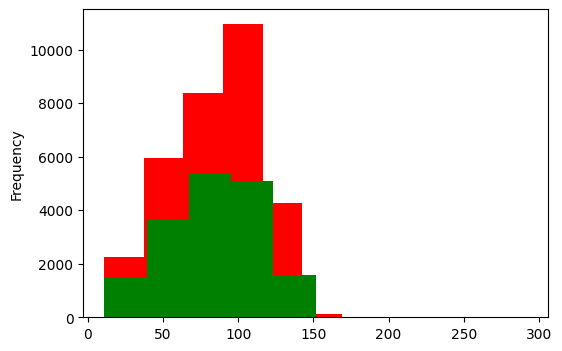

In [9]:
train_length = train['tweet'].str.len().plot(kind='hist', color='red', figsize=(6, 4))
test_length = test['tweet'].str.len().plot(kind='hist', color='green', figsize=(6, 4))

In [10]:
train['length'] = train['tweet'].str.len()
test['length'] = test['tweet'].str.len()

In [11]:
train.groupby('label').describe()

id                                                                
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25  \
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                 length                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

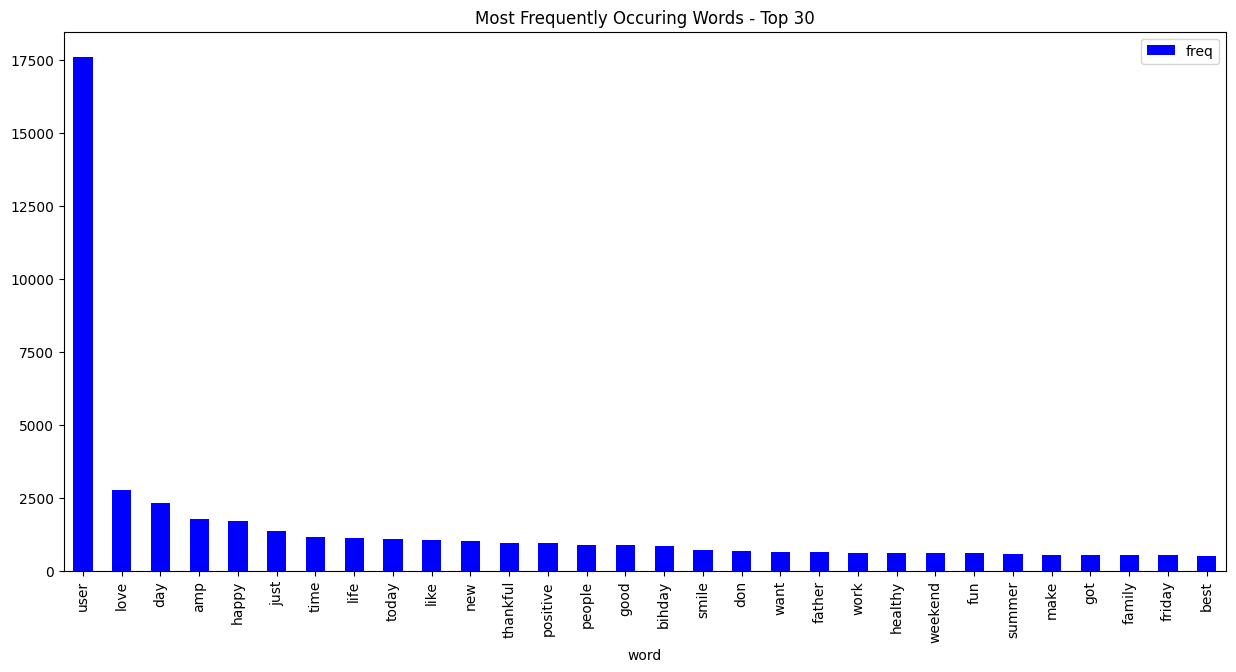

In [12]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color='blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Tweets')

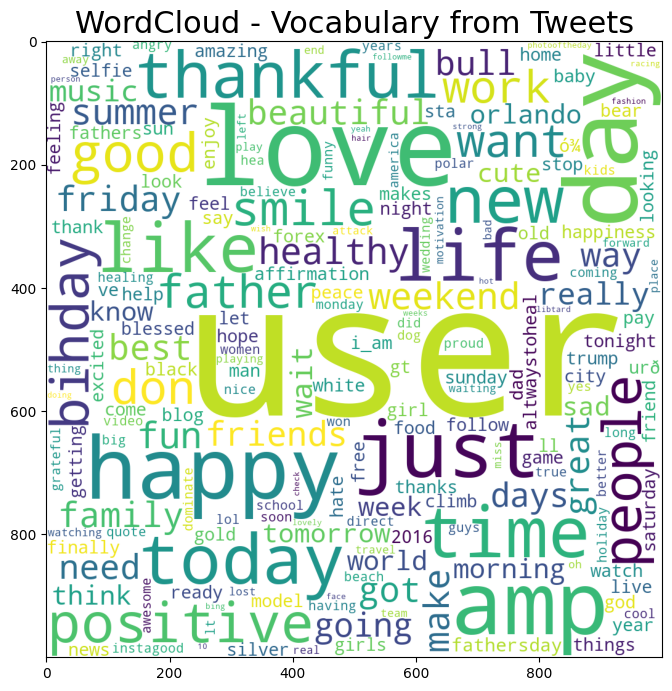

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width=1000, height=1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Tweets", fontsize=22)

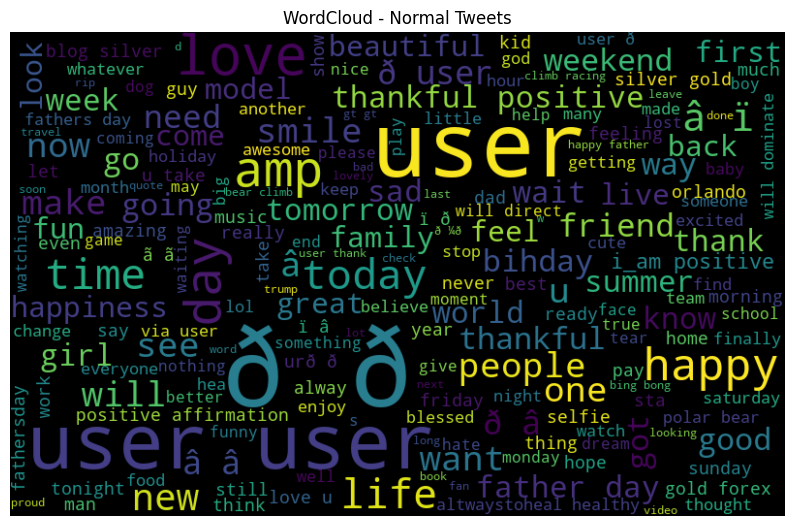

In [14]:
normal_words = ' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud - Normal Tweets')
plt.show()

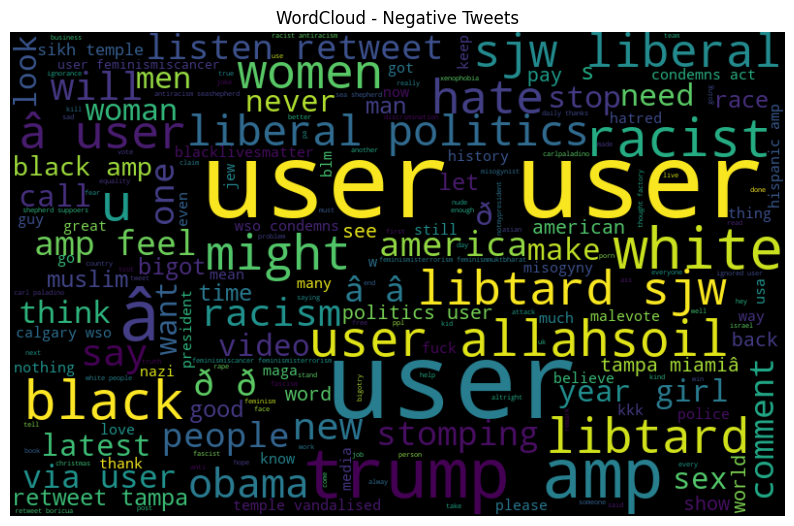

In [15]:
negative_words = ' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud - Negative Tweets')
plt.show()

In [16]:
def extract_hashtags(tweet):
    hashtags = []
    for i in tweet:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [17]:
regular_ht = extract_hashtags(train['tweet'][train['label'] == 0])
negative_ht = extract_hashtags(train['tweet'][train['label'] == 1])

regular_ht = sum(regular_ht, [])
negative_ht = sum(negative_ht, [])

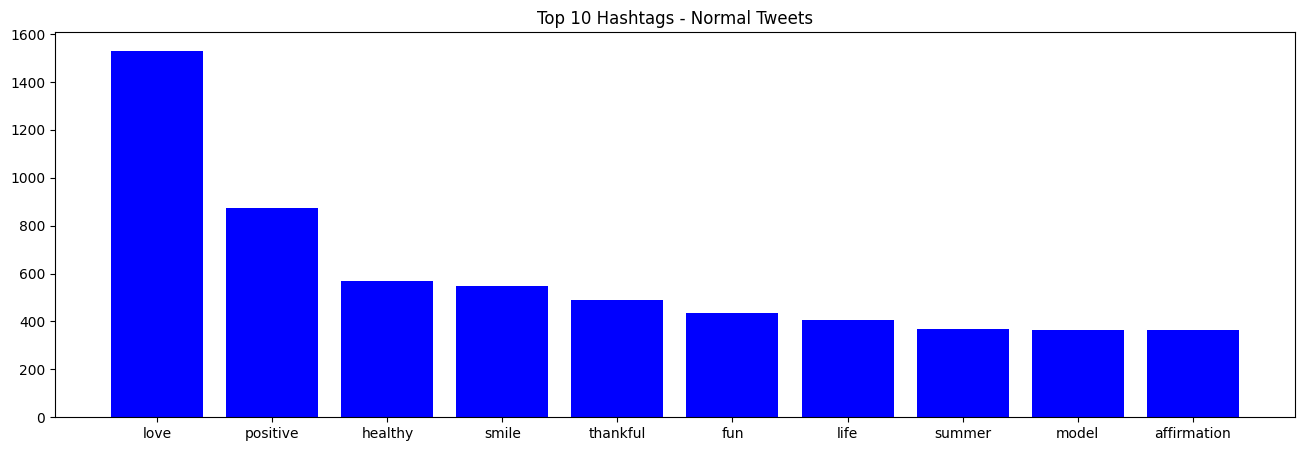

In [18]:
a = nltk.FreqDist(regular_ht)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16, 5))
plt.bar(d['Hashtag'], d['Count'], color='blue')
plt.title('Top 10 Hashtags - Normal Tweets')
plt.show()

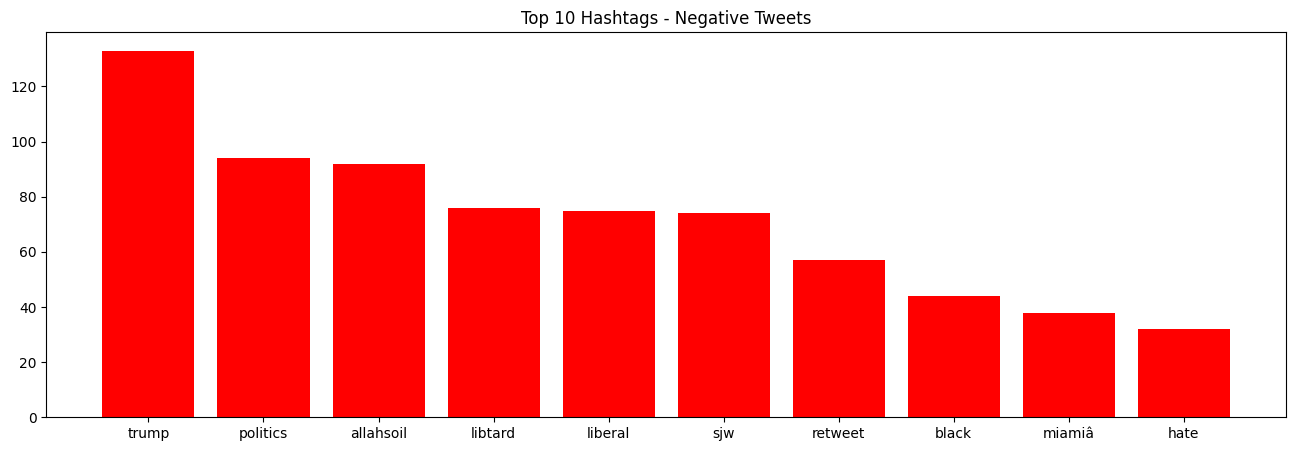

In [19]:
a = nltk.FreqDist(negative_ht)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16, 5))
plt.bar(d['Hashtag'], d['Count'], color='red')
plt.title('Top 10 Hashtags - Negative Tweets')
plt.show()

In [20]:
from gensim.models import Word2Vec
tokenized_tweet = train['tweet'].apply(lambda x: x.split())

model_w2v = Word2Vec(tokenized_tweet, vector_size=200, window=5, min_count=2, sg=1, hs=0, negative=10, workers=2, seed=34)
model_w2v.train(tokenized_tweet, total_examples=len(train['tweet']), epochs=20)

(6109675, 8411580)

In [21]:
model_w2v.wv.most_similar(positive='dinner')

[('spaghetti', 0.6214743852615356),
 ('podium', 0.6001140475273132),
 ('enroute', 0.5826249122619629),
 ('#prosecco', 0.582332968711853),
 ('sister!!', 0.5770423412322998),
 ('shopping!', 0.5765421986579895),
 ('weekend...', 0.5764912366867065),
 ('#pamper', 0.5735845565795898),
 ('ð\x9f\x91\x8dð\x9f\x8f»ð\x9f\x91\x8dð\x9f\x8f»ð\x9f\x91\x8dð\x9f\x8f»â\x9d¤ï¸\x8fâ\x9d¤ï¸\x8f',
  0.5673363208770752),
 ('#wanderlust', 0.5657327771186829)]

In [22]:
model_w2v.wv.most_similar(positive='trump')

[('donald', 0.5727846622467041),
 ('fuhered', 0.5437322854995728),
 ('unfit', 0.5418023467063904),
 ('churchill', 0.5400397181510925),
 ('paladino', 0.5377013683319092),
 ('unstable,', 0.534902811050415),
 ('#dumptrump', 0.534477710723877),
 ("trump's", 0.529251754283905),
 ('suppoer', 0.5282569527626038),
 ('suppoer.', 0.5250775218009949)]

In [23]:
model_w2v.wv.most_similar(negative='hate')

[('#crafts', 0.03514307364821434),
 ('#foodie', 0.025225074961781502),
 ('#staup', 0.023481322452425957),
 ('ð\x9f\x8d»', 0.01657579280436039),
 ('â\x9c\x88ï¸\x8f', 0.01438924577087164),
 ('#humpday', 0.01390047650784254),
 ('@', 0.00739080086350441),
 ('hotel', 0.0049170576967298985),
 ('#hungry', 0.0034321832936257124),
 ('#progress', 0.0021189807448536158)]

In [24]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
train_corpus = []

for i in range(0, len(train)):
    tweet = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    train_corpus.append(tweet)

In [26]:
test_corpus = []

for i in range(0, len(test)):
    tweet = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    test_corpus.append(tweet)

In [27]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:,1]

print(X.shape)
print(y.shape)

(31962, 2500)
(31962,)


In [28]:
x_test = cv.transform(test_corpus).toarray()
print(x_test.shape)

(17197, 2500)


In [29]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_val=sc.transform(x_val)
x_test=sc.transform(x_test)

In [31]:
rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)

print("Training Accuracy: ", rf.score(x_train, y_train))
print("Validation Accuracy: ", rf.score(x_val, y_val))
print("F1 Score: ", f1_score(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
print(cm)

Training Accuracy:  0.9947436485753619
Validation Accuracy:  0.9505693905643849
F1 Score:  0.594039054470709
[[7307  125]
 [ 270  289]]


In [32]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
y_pred = logistic.predict(x_val)

print("Training Accuracy: ", logistic.score(x_train, y_train))
print("Validation Accuracy: ", logistic.score(x_val, y_val))
print("F1 Score: ", f1_score(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
print(cm)

Training Accuracy:  0.9851487213716574
Validation Accuracy:  0.9416843949443123
F1 Score:  0.5933682373472949
[[7185  247]
 [ 219  340]]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_val)

print("Training Accuracy: ", decision_tree.score(x_train, y_train))
print("Validation Accuracy: ", decision_tree.score(x_val, y_val))
print("F1 Score: ", f1_score(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
print(cm)

Training Accuracy:  0.9991656585040257
Validation Accuracy:  0.932048554623952
F1 Score:  0.5386576040781649
[[7131  301]
 [ 242  317]]


In [34]:
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_val)

print("Training Accuracy: ", svm.score(x_train, y_train))
print("Validation Accuracy: ", svm.score(x_val, y_val))
print("F1 Score: ", f1_score(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
print(cm)

In [ ]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_val)

print("Training Accuracy: ", xgb.score(x_train, y_train))
print("Validation Accuracy: ", xgb.score(x_val, y_val))
print("F1 Score: ", f1_score(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
print(cm)